In [35]:
# setting up all of the packages!
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
import torch
import torch.nn as nn

import rasterio
import rioxarray as rio
import numpy as np
import pandas as pd

# print(os.getcwd())

from utils import * 

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
%load_ext autoreload
%autoreload 2

plt.rcParams['savefig.dpi'] = 400
plt.rcParams['font.size'] = 13
plt.rcParams["legend.frameon"] = False

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Import and prepare our predictor and predictant datasets
predictor: (X, TerraClim climate variables), predictant: (Y, MODIS LAI) data

In [36]:
# establish path and open as an array
path = "/home/jovyan/large_files/climLai_masked_anom.nc"
# path = "/home/jovyan/large_files/climLai_merged.nc"
ds_combined = xr.open_dataset(path)

In [37]:
# Count NaNs per variable
for var in ds_combined.data_vars:
    print(var, ds_combined[var].isnull().sum().item())

tmmx 598044
tmmn 598044
pr 598044
pdsi 598044
def 598044
vpd 598044
soil 598044
lai 598044


<xarray.Dataset> Size: 77MB
Dimensions:      (time: 228, lat: 71, lon: 74)
Coordinates:
  * time         (time) datetime64[ns] 2kB 2002-01-31 2002-02-28 ... 2020-12-31
  * lat          (lat) float32 284B -9.825 -9.875 -9.925 ... -13.28 -13.33
  * lon          (lon) float32 296B -72.38 -72.32 -72.28 ... -68.78 -68.72
    spatial_ref  (time) int64 2kB ...
    month        (time) int64 2kB ...
Data variables:
    tmmx         (time, lat, lon) float64 10MB nan nan nan nan ... nan nan nan
    tmmn         (time, lat, lon) float64 10MB nan nan nan nan ... nan nan nan
    pr           (time, lat, lon) float64 10MB nan nan nan nan ... nan nan nan
    pdsi         (time, lat, lon) float64 10MB nan nan nan nan ... nan nan nan
    def          (time, lat, lon) float64 10MB nan nan nan nan ... nan nan nan
    vpd          (time, lat, lon) float64 10MB nan nan nan nan ... nan nan nan
    soil         (time, lat, lon) float64 10MB nan nan nan nan ... nan nan nan
    lai          (time, lat, lon) flo

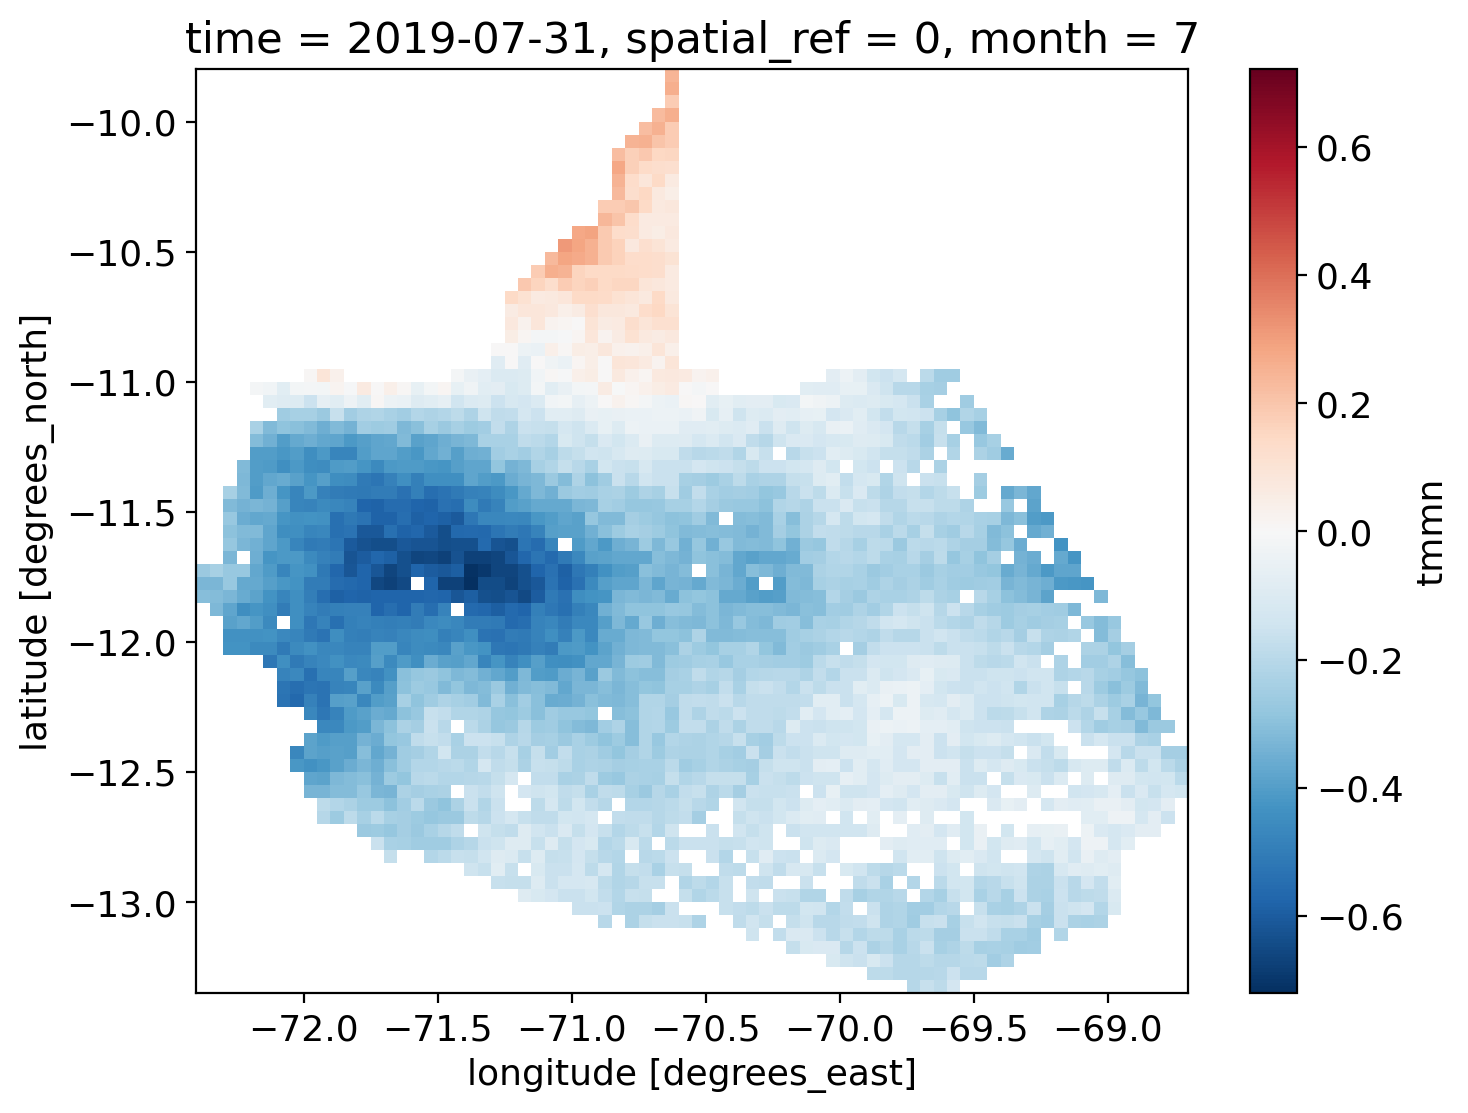

In [38]:
# take a look at the ds_combined dataset
print(ds_combined)
ds_combined.tmmn.isel(time=210).plot(figsize=(8,6))

In [39]:
# the data array has 3 dimensions. Stack the coordinate values to go from 3d to 2d.
ds_stacked = ds_combined.stack(stacked=("lat", "lon"))

In [40]:
# convert to data frame
df_combined = ds_stacked.to_dataframe().dropna()

print(df_combined)

                                      tmmx      tmmn          pr      pdsi  \
time       lat        lon                                                    
2002-01-31 -9.825002  -70.625000  0.710526  0.610526  127.473684  6.951053   
           -9.875002  -70.625000  0.663158  0.657895  118.894737  7.005263   
           -9.925001  -70.625000  0.642105  0.626316  114.736842  6.954737   
           -9.975001  -70.674995  0.678947  0.642105  108.000000  6.787368   
                      -70.625000  0.626316  0.621053  110.473684  6.945263   
...                                    ...       ...         ...       ...   
2020-12-31 -13.275002 -69.474998  0.763158  0.589474  104.684211 -2.172632   
           -13.325002 -69.724998  0.784211  0.642105  103.894737 -0.917368   
                      -69.674995  0.800000  0.626316  104.526316 -0.950000   
                      -69.625000  0.763158  0.657895  106.368421 -1.386316   
                      -69.574997  0.800000  0.610526  107.631579

In [41]:
# from dataframe generate the x_df (ONLY climate predictor variables, drop the lai column)
x_df = df_combined.drop(columns=["lai",
                                 "def",
                                 "tmmn",
                                 "spatial_ref"])

In [42]:
# look at x_df
x_df.head()

tmmx          pr      pdsi       vpd  \
time       lat       lon                                                    
2002-01-31 -9.825002 -70.625000  0.710526  127.473684  6.951053  0.092632   
           -9.875002 -70.625000  0.663158  118.894737  7.005263  0.092632   
           -9.925001 -70.625000  0.642105  114.736842  6.954737  0.090526   
           -9.975001 -70.674995  0.678947  108.000000  6.787368  0.099474   
                     -70.625000  0.626316  110.473684  6.945263  0.096842   

                                         soil  month  
time       lat       lon                              
2002-01-31 -9.825002 -70.625000  5.684342e-14      1  
           -9.875002 -70.625000 -5.684342e-14      1  
           -9.925001 -70.625000  0.000000e+00      1  
           -9.975001 -70.674995 -5.684342e-14      1  
                     -70.625000  5.684342e-14      1

In [43]:
# from dataframe generate y_df (ONLY lai)
y_df = df_combined.drop(columns=["spatial_ref",
                                 "tmmx",
                                 "tmmn",
                                 "pr",
                                 "pdsi",
                                 "def",
                                 "vpd",
                                 "soil"])
# look at y_df
y_df.head()

lai  month
time       lat       lon                        
2002-01-31 -9.825002 -70.625000  0.657735      1
           -9.875002 -70.625000  0.193407      1
           -9.925001 -70.625000  0.175278      1
           -9.975001 -70.674995  0.773132      1
                     -70.625000  0.000997      1

## Split our data into training, validation and testing
Look at the entire time sequence of our data: 19 years, 12 months per year
(19yrs x 12months) = 228 time steps

We want the last two years to be our testing dataset: 2019 and 2020
Therefore, the first 17 tears are our training and validation data
Of this, 80% must be training (14 years), 20% must be validation (3 years)

So the final break-down is:
Training: 2002-2015 (14yrs x 12months = 168 ts)
Validation: 2016-2018 (3yrs x 12months = 36 ts)
Testing: 2019-2020 (2yrs x 12months = 24 ts)

In [44]:
# look at the entire time sequence of our data
first_time = x_df.index.get_level_values("time")[0]
last_time  = x_df.index.get_level_values("time")[-1]

print('time 0 =', first_time)
print('time last =', last_time)

time 0 = 2002-01-31 00:00:00
time last = 2020-12-31 00:00:00


In [45]:
# splitting the data according to the time splits above

# establish the before and after for the testing set
times = x_df.index.get_level_values("time")
mask_before_testing = times < '2020-01-31 00:00:00'
mask_after_testing  = times >= '2020-01-31 00:00:00'

# split the data into training + validation and testing
x_df_trainval = x_df.loc[mask_before_testing]
x_df_test = x_df.loc[mask_after_testing]
y_df_trainval = y_df.loc[mask_before_testing]
y_df_test = y_df.loc[mask_after_testing]

# split the training and validation data
mask_before_trainval = times < '2018-01-31 00:00:00'
mask_after_trainval = times >= '2018-01-31 00:00:00'

# split trainval into training and validation data
x_df_train = x_df.loc[mask_before_trainval]
x_df_valid = x_df.loc[mask_after_trainval]
y_df_train = y_df.loc[mask_before_trainval]
y_df_valid = y_df.loc[mask_after_trainval]

In [46]:
# test to make sure the splits worked:
print('shape x_df_train', x_df_train.shape)
print('shape x_df_valid', x_df_valid.shape)
print('shape x_df_test', x_df_test.shape)

print('shape y_df_train', y_df_train.shape)
print('shape y_df_valid', y_df_valid.shape)
print('shape y_df_test', y_df_test.shape)

shape x_df_train (505152, 6)
shape x_df_valid (94716, 6)
shape x_df_test (31572, 6)
shape y_df_train (505152, 2)
shape y_df_valid (94716, 2)
shape y_df_test (31572, 2)


# SKIP THIS! WE SCALE LATER ON! AND BECAUSE WE ARE STANDARDIZING ON SEPERATE TRAINING AND VALIDATION WE ARE INTRODUCING BIAS. THIS IS WRONG. 
## Standardize our data to prepare it for LSTM ingestion

Standardize our data to prepare it for LSTM ingestion :o
We want to standardize per location, to avoid losing any spatial relationships

There is a question here of whether we should be standardizing the y values because NDVI is already a constrained abd bounded value <-- much to think about

In [47]:
# standardizing our y_df_train values
def standardize_per_location(y_df_train, feature_col="lai"):
    # Extract levels
    idx = y_df_train.index

    # Create a DataFrame from index levels for grouping
    idx_df = pd.DataFrame({
        'time': idx.get_level_values('time'),
        'lat': idx.get_level_values('lat'),
        'lon': idx.get_level_values('lon'),
        feature_col: y_df_train[feature_col].values
    })

    # Group by location (lat, lon)
    def standardize_group(group):
        vals = group[feature_col]
        standardized_vals = (vals - vals.mean()) / vals.std()
        group[feature_col] = standardized_vals
        return group

    y_df_train_sd = idx_df.groupby(['lat', 'lon']).apply(standardize_group)

    # Restore MultiIndex
    y_df_train_sd.set_index(['time', 'lat', 'lon'], inplace=True)
    y_df_train_sd = y_df_train_sd.sort_index()

    return y_df_train_sd[[feature_col]]

# Apply
y_df_train_sd = standardize_per_location(y_df_train, feature_col="lai")

/tmp/ipykernel_15358/1611225121.py:21: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  y_df_train_sd = idx_df.groupby(['lat', 'lon']).apply(standardize_group)


In [48]:
# standardizing our y_df_valid values
def standardize_per_location(y_df_valid, feature_col="lai"):
    # Extract levels
    idx = y_df_valid.index

    # Create a DataFrame from index levels for grouping
    idx_df = pd.DataFrame({
        'time': idx.get_level_values('time'),
        'lat': idx.get_level_values('lat'),
        'lon': idx.get_level_values('lon'),
        feature_col: y_df_valid[feature_col].values
    })

    # Group by location (lat, lon)
    def standardize_group(group):
        vals = group[feature_col]
        standardized_vals = (vals - vals.mean()) / vals.std()
        group[feature_col] = standardized_vals
        return group

    y_df_valid_sd = idx_df.groupby(['lat', 'lon']).apply(standardize_group)

    # Restore MultiIndex
    y_df_valid_sd.set_index(['time', 'lat', 'lon'], inplace=True)
    y_df_valid_sd = y_df_valid_sd.sort_index()

    return y_df_valid_sd[[feature_col]]

# Apply
y_df_valid_sd = standardize_per_location(y_df_valid, feature_col="lai")

/tmp/ipykernel_15358/680808079.py:21: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  y_df_valid_sd = idx_df.groupby(['lat', 'lon']).apply(standardize_group)


In [50]:
def standardize_per_location(df, feature_cols):
    """
    Standardize multiple feature columns per location (lat, lon) over time.

    Parameters:
    - df: pandas DataFrame with MultiIndex (time, lat, lon)
    - feature_cols: list of feature column names to standardize

    Returns:
    - pandas DataFrame with standardized features, same MultiIndex
    """

    idx = df.index

    # Build a DataFrame from the MultiIndex levels and feature columns
    data = {
        'time': idx.get_level_values('time'),
        'lat': idx.get_level_values('lat'),
        'lon': idx.get_level_values('lon')
    }
    # Add all feature columns to the data dict
    for col in feature_cols:
        data[col] = df[col].values

    idx_df = pd.DataFrame(data)

    # Group by location (lat, lon) and standardize each feature column
    def standardize_group(group):
        for col in feature_cols:
            vals = group[col]
            group[col] = (vals - vals.mean()) / vals.std()
        return group

    standardized_df = idx_df.groupby(['lat', 'lon']).apply(standardize_group)

    # Restore MultiIndex and sort
    standardized_df.set_index(['time', 'lat', 'lon'], inplace=True)
    standardized_df = standardized_df.sort_index()

    # Return only the standardized feature columns (MultiIndex preserved)
    return standardized_df[feature_cols]


feature_columns = ["tmmx", 
                   # "tmmn", 
                   "pr", 
                   "pdsi", 
                   # "def", 
                   "vpd", 
                   "soil"]  # your features
x_df_train_sd = standardize_per_location(x_df_train, feature_columns)
x_df_valid_sd = standardize_per_location(x_df_valid, feature_columns)

/tmp/ipykernel_15358/2513706806.py:34: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  standardized_df = idx_df.groupby(['lat', 'lon']).apply(standardize_group)
/tmp/ipykernel_15358/2513706806.py:34: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  standardized_df = idx_df.groupby(['lat', 'lon']).apply(standardize_group)


## Reshape data to feed into the LSTM model
okay let's do this!! >:O

In [51]:
# import our missing packages!
from sklearn.preprocessing import StandardScaler
import torch
from torch.utils.data import Dataset, DataLoader

In [52]:
# 0 - Ensure Time is a column of our data
# Time is currently an INDEX not a column of our data, we need to convert it into a COLUMN
def ensure_time_column(df):
    """
    If time is the index, convert it into a column called 'time'.
    Works for both training and validation dataframes.
    """
    if "time" not in df.columns:
        # index must be time
        df = df.reset_index().rename(columns={"index": "time"})
    df["time"] = pd.to_datetime(df["time"])
    return df


# 1 - Merge the X (predictors, climate variables) and Y (predictands, modis lai) datasets
def merge_xy(x_df, y_df):
    x_df = ensure_time_column(x_df)
    y_df = ensure_time_column(y_df)
    
    df = x_df.merge(y_df, on=["time", "lat", "lon"], how="inner")
    df = df.sort_values(["lat", "lon", "time"]).reset_index(drop=True)
    return df

train_df = merge_xy(x_df_train, y_df_train)
valid_df = merge_xy(x_df_valid, y_df_valid)

In [53]:
# 2. scale the climate inputs, DO NOT DO THIS IF YOU HAVE PROPERLY STANDARDIZED
# in this case we have not properly standardized, so we will scale
# find the mean and std of each feature in the training dataset and standardize
# then use the mean and std of the TRAINING data to transform the validation data
feature_cols = ["tmmx", 
                # "tmmn", 
                "pr", 
                "pdsi", 
                # "def", 
                "vpd", 
                "soil"]

scaler = StandardScaler()
train_df[feature_cols] = scaler.fit_transform(train_df[feature_cols]) # TRAINING DATA, CALL THE FIT_TRANSFORM
valid_df[feature_cols] = scaler.transform(valid_df[feature_cols]) # VALIDATION DATA, CALL THE TRANSFORM

In [54]:
# let's check our standardization
train_stats = train_df[feature_cols].agg(['mean','std']).T
valid_stats = valid_df[feature_cols].agg(['mean','std']).T
print("TRAIN\n", train_stats)
print("VALID\n", valid_stats)

TRAIN
               mean       std
tmmx -2.520613e-17  1.000001
pr    9.564825e-18  1.000001
pdsi -2.745667e-17  1.000001
vpd  -4.321050e-17  1.000001
soil  2.475602e-18  1.000001
VALID
           mean       std
tmmx  1.118129  1.346979
pr    0.060043  0.745810
pdsi  0.090729  0.662442
vpd   1.701748  2.796073
soil  0.005186  1.081609


In [55]:
from scipy.stats import ks_2samp
for col in feature_cols:
    stat, p = ks_2samp(train_df[col].dropna(), valid_df[col].dropna())
    print(f"{col}: KS stat={stat:.3f}, p={p:.3e}")

tmmx: KS stat=0.410, p=0.000e+00
pr: KS stat=0.101, p=0.000e+00
pdsi: KS stat=0.163, p=0.000e+00
vpd: KS stat=0.441, p=0.000e+00
soil: KS stat=0.026, p=5.126e-47


In [56]:
train_df['year'] = train_df['time'].dt.year
valid_df['year'] = valid_df['time'].dt.year
agg_train = train_df.groupby('year')[feature_cols].mean()
agg_valid = valid_df.groupby('year')[feature_cols].mean()
print(agg_train.head())
print(agg_valid.head())

          tmmx        pr      pdsi       vpd      soil
year                                                  
2002 -0.259852  0.596133  1.493951 -0.041389  0.021505
2003 -0.169619  0.101912  1.027069  0.053352  0.171563
2004 -0.206688  0.230859  0.670122  0.005469  0.558074
2005 -0.494336 -0.724114 -1.280750 -0.129408 -1.379791
2006 -0.236752 -0.067570 -1.329413 -0.062762  0.118655
          tmmx        pr      pdsi       vpd      soil
year                                                  
2018 -0.088261  0.003477  0.081025 -0.697522  0.587541
2019  1.371037  0.353248  0.399097  1.600694 -0.168242
2020  2.071612 -0.176595 -0.207936  4.202073 -0.403742


In [57]:
# 3 build the lstm sequences for each pixel, establish 3 timesteps (months) as our "look-back" window
def build_sequences(df, feature_cols, lookback):
    X_list, y_list, coords = [], [], []

    for (lat, lon), group in df.groupby(["lat", "lon"]):
        group = group.sort_values("time")

        X_vals = group[feature_cols].values
        y_vals = group["lai"].values

        for i in range(len(group) - lookback):
            X_list.append(X_vals[i:i+lookback])
            y_list.append(y_vals[i+lookback])
            coords.append((lat, lon))

    return (
        np.array(X_list, dtype=np.float32),
        np.array(y_list, dtype=np.float32),
        coords,
    )


lookback = 3 # will use the past 6 months (time-steps of data) to get the next 7th month

X_train_np, y_train_np, train_coords = build_sequences(train_df, feature_cols, lookback)
X_valid_np, y_valid_np, valid_coords = build_sequences(valid_df, feature_cols, lookback)

print("Train X shape:", X_train_np.shape) # (len_t), lookback, feat
print("Valid X shape:", X_valid_np.shape) # (len_v), lookback, feat

# Train X shape and Valid X shape should have the same lookback and features (the last two values)
# BUT should differ in their first domension, with Train beging larger reflecting there is a greater ammount of data going into training

Train X shape: (497259, 3, 5)
Valid X shape: (86823, 3, 5)


In [58]:
# 4 convert to PYTORCH dataset, ready for model ingestion
class ClimateLAIDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_dataset = ClimateLAIDataset(X_train_np, y_train_np)
valid_dataset = ClimateLAIDataset(X_valid_np, y_valid_np)


In [59]:
# 5 split into training, validation, testing data
# current data is split 80% to training, 20% to validation
# we will split the 20% of validation into 10% validation, 10% testing

# Split our validation into valid and test datasets
#valid_size = int(0.1 * len(valid_dataset))
#test_size = len(valid_dataset) - valid_size
#valid_dataset, test_dataset = torch.utils.data.random_split(valid_dataset, [valid_size, test_size])

In [60]:
# 6 DATALOADERS, both should be shuffle=false, according to Pierre
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=False)
val_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False)
print('something')

something


## Define LSTM structure

In [61]:
# set hyperparameters
n_neuron       = 64
activation     = 'ReLU'
num_epochs     = 50
learning_rate  = 0.00001
minibatch_size = 64
model_num      = 1

In [62]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [73]:
# model definition
import torch.nn as nn

class LAI_LSTM(nn.Module):
    def __init__(self, num_features=5, hidden_size=64, num_layers=1):
        super(LAI_LSTM, self).__init__()

        self.lstm = nn.LSTM(
            input_size=num_features,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True
        )

        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        # Debug print statements
        #print("\n===== FORWARD PASS DEBUG =====")
        #print("Input to LSTM:", x.shape)

        # Run LSTM
        output, (h_n, c_n) = self.lstm(x)
        #print("LSTM output:", output.shape)      # (batch, seq_len, hidden)
        #print("h_n:", h_n.shape)                 # (num_layers, batch, hidden)
        #print("c_n:", c_n.shape)

        # Fully connected layer on last hidden state
        out = self.fc(h_n[-1])
        #print("After FC:", out.shape)            # (batch, 1)

        # Squeeze last dimension only
        out = out.squeeze(1)
        #print("Final output:", out.shape)        # (batch,)

        #print("===== END FORWARD DEBUG =====\n")
        return out

model = LAI_LSTM(num_features=5, hidden_size=64, num_layers=1)
model.to(device)

LAI_LSTM(
  (lstm): LSTM(5, 64, batch_first=True)
  (fc): Linear(in_features=64, out_features=1, bias=True)
)

In [74]:
# define the optimizer (ADAM), and the evaluation criterion: MSELoss
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.MSELoss()

In [75]:
# checking for NaNs one more time
np.isnan(X_valid_np).any(), np.isnan(y_valid_np).any()

(np.False_, np.False_)

In [76]:
# checking standardization
print(train_df[feature_cols].mean())
print(valid_df[feature_cols].mean())

tmmx   -2.520613e-17
pr      9.564825e-18
pdsi   -2.745667e-17
vpd    -4.321050e-17
soil    2.475602e-18
dtype: float64
tmmx    1.118129
pr      0.060043
pdsi    0.090729
vpd     1.701748
soil    0.005186
dtype: float64


## debugging, ignore! DO NOT RUN

In [21]:
print("X_train shape:", X_train_np.shape)
print("y_train shape:", y_train_np.shape)

X_train shape: (2159688, 6, 7)
y_train shape: (2159688,)


In [22]:
## de-bugging!! ignore
# ----- RUN ONE BATCH ONLY -----
X_batch, y_batch = next(iter(train_loader))

print("Batch X:", X_batch.shape)
print("Batch y:", y_batch.shape)

_ = model(X_batch)

Batch X: torch.Size([32, 6, 7])
Batch y: torch.Size([32])


In [69]:
# debugging training loop!! ignore!!
for X_batch, y_batch in train_loader:
    X_batch = X_batch.to(device)
    y_batch = y_batch.to(device)

    optimizer.zero_grad()

    outputs = model(X_batch)

    print("outputs:", outputs.shape)
    print("y_batch:", y_batch.shape)

    loss = criterion(outputs, y_batch)
    loss.backward()
    optimizer.step()

    print("LOSS INPUT SHAPES →", outputs.shape, y_batch.shape)
    
    break 


===== FORWARD PASS DEBUG =====
Input to LSTM: torch.Size([32, 6, 7])
LSTM output: torch.Size([32, 6, 64])
h_n: torch.Size([1, 32, 64])
c_n: torch.Size([1, 32, 64])
After FC: torch.Size([32, 1])
Final output: torch.Size([32])
===== END FORWARD DEBUG =====

outputs: torch.Size([32])
y_batch: torch.Size([32])
LOSS INPUT SHAPES → torch.Size([32]) torch.Size([32])


## Training and saving the model

In [ ]:
from utils import pytorch_train
# we will be using the same function as seen in the CNN_example.ipynb notebook 

train_losses_mse, val_losses_mse = pytorch_train(model, optimizer, criterion = criterion, 
                                                 device = device, 
                                                 train_loader = train_loader, val_loader = val_loader, 
                                                 num_epochs = num_epochs)

Epoch 1/50, Train Loss: 0.1563, Val Loss: 0.1355


# okay, SO!
I changed a couple of things.
1. I made our time-scale only look at data BEFORE the 2015 drought
2. I decreased the learning rate (made it much smaller)
3. I decreased the look-back window, made it 3

In [ ]:
#num_epochs = 50
#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#model = LAI_LSTM(num_features=7, hidden_size=64, num_layers=1).to(device)
#criterion = nn.MSELoss()
#optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

#for epoch in range(num_epochs):

    # ===== TRAINING =====
#    model.train()
#    train_loss = 0.0

#    for X_batch, y_batch in train_loader:
#        X_batch = X_batch.to(device)        # (batch, seq, features)
#        y_batch = y_batch.to(device)        # (batch,)

#        optimizer.zero_grad()

#        y_pred = model(X_batch)             # → (batch,)
#        loss = criterion(y_pred, y_batch)   # matches perfectly
#        loss.backward()
#        optimizer.step()

#        train_loss += loss.item() * len(X_batch)

#    train_loss /= len(train_loader.dataset)

    # ===== VALIDATION =====
#    model.eval()
#    val_loss = 0.0

#    with torch.no_grad():
#        for X_batch, y_batch in val_loader:
#            X_batch = X_batch.to(device)
#            y_batch = y_batch.to(device)

#            y_pred = model(X_batch)
#            loss = criterion(y_pred, y_batch)
#            val_loss += loss.item() * len(X_batch)

#    val_loss /= len(val_loader.dataset)

#    print(f"Epoch {epoch+1}/{num_epochs}  "
#          f"| Train Loss: {train_loss:.4f}  "
#          f"| Val Loss: {val_loss:.4f}")

Epoch 1/50  | Train Loss: nan  | Val Loss: nan


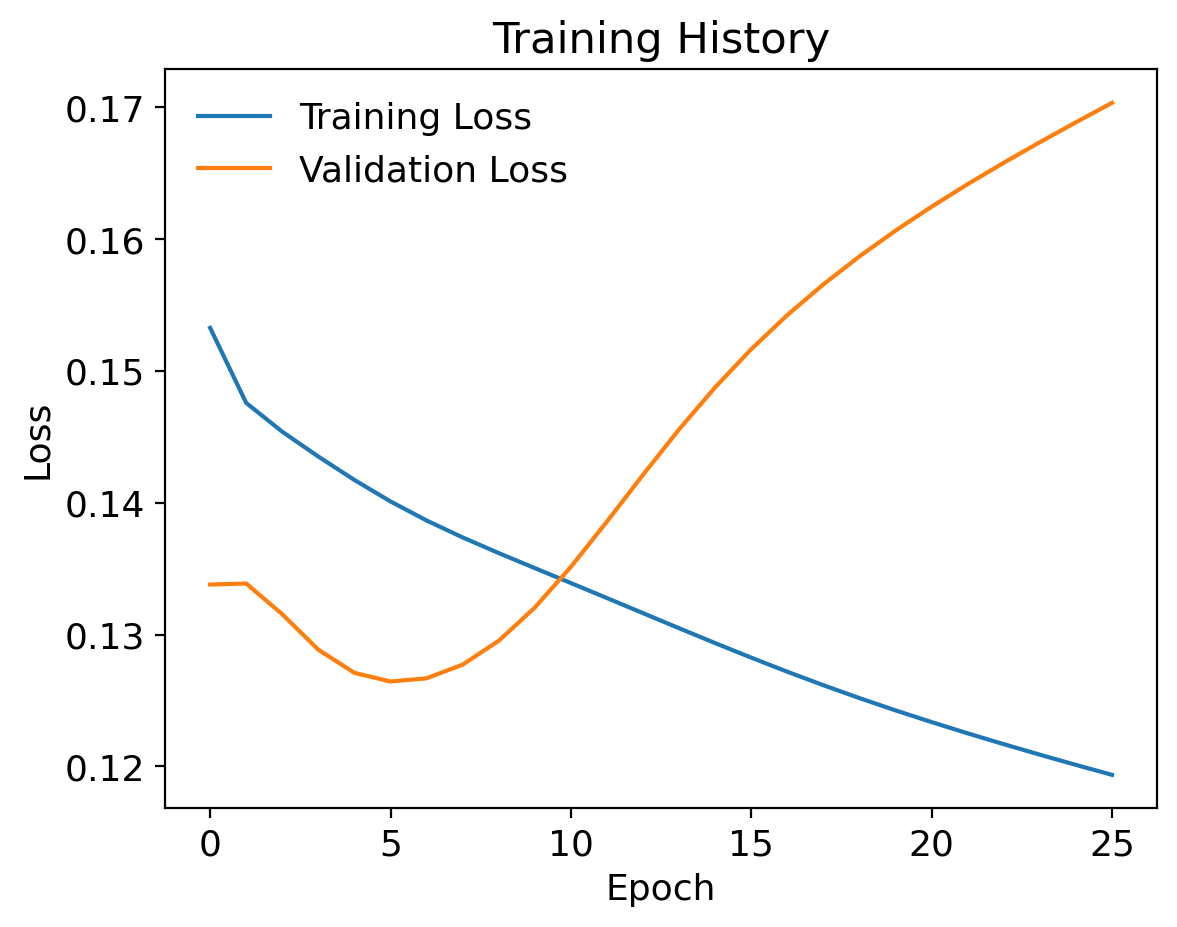

In [34]:
plot_history(train_losses_mse, val_losses_mse)

In [ ]:
# export and SAVE model
model_path = os.path.join(cwd,'saved_model_X')
make_dir(model_path)

# Save the model weights to a pth file.
torch.save(model.state_dict(), os.path.join(model_path,'LSTM_model_weights_.pth'))

#### MISSING TASKS/NEXT STEPS
## 1 figure out data splitting
Currently, I am splitting our data into training and validation at the start of the script and using the timesteps as my splits to have 15 years of training data, 4 years of validation data, which can then be split into validation and training data
The example LSTM script brings in the training and testing data separatley, and then gets the validation data from the training data...
So, I am unsure if I should:
a) go back to the start of the script and split 90% to training, 10% to testing, and then from that 90% generate my training data after all the processing
b) Leave my splitting as is, and split my validation data (currently 20% of my data) into 10% validation, 10% testing
Note that option b) means that the testing data has been standardized/scaled alongside the validation data. I am unclear if this is an issue.

## 2 define the model architecture by setting hyperparameters

## 3 actually define the model and the optimizer (ADAM)

## 4 run the model and save!

## evaluate the trained model on the testing data

